In [1]:
import matplotlib.pyplot as plt, numpy as np, seaborn as sns, scipy.stats as stats, pandas as pd, os, glob
import ast
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


## read df and filter

In [15]:
subj = ['202509', 'tori'][0]
df = pd.read_csv(glob.glob(f'../results/*{subj}*csv')[0])[:-1]

# 1.
for col in ['positions']:
    if type(df[col][0]) == str:
        df[col] = df[col].apply(lambda x: ast.literal_eval(x)) # convert str to list

# 2. # get dist between target & last position
df['MAE_unnormed'] = abs(df['target_pos'] - df['positions'].apply(lambda x: x[-1]))
df['MAE_normed'] = np.where(
    ((df['condition'] == 'pen_comp') & (df['valence'] == 'pen')) | ((df['condition'] == 'rew_comp') & (df['valence'] == 'rew')),
    df['MAE_unnormed']*2, 
    df['MAE_unnormed']
)

# 2.
df['dist'] = df['positions'].apply(lambda x: abs(x[-1] - x[0]))
df['avg_speed'] = df['dist'] / df['trials.submit_resp.rt']

# 4.
df['choice'] = df['outcome'].apply(lambda x: 1 if abs(x) == 2 else 0 if abs(x) == 1 else 0)
# df = df[df['choice'] != 0]

# 5.
# filtering out easy trials
df_hard = df[df['target_pos'] - df['div_pos'] <= .05].copy()
print(f'% trials with |target-divider| <= .1: {len(df_hard)/len(df): .02f}')

% trials with |target-divider| <= .1:  0.57


## duration checks

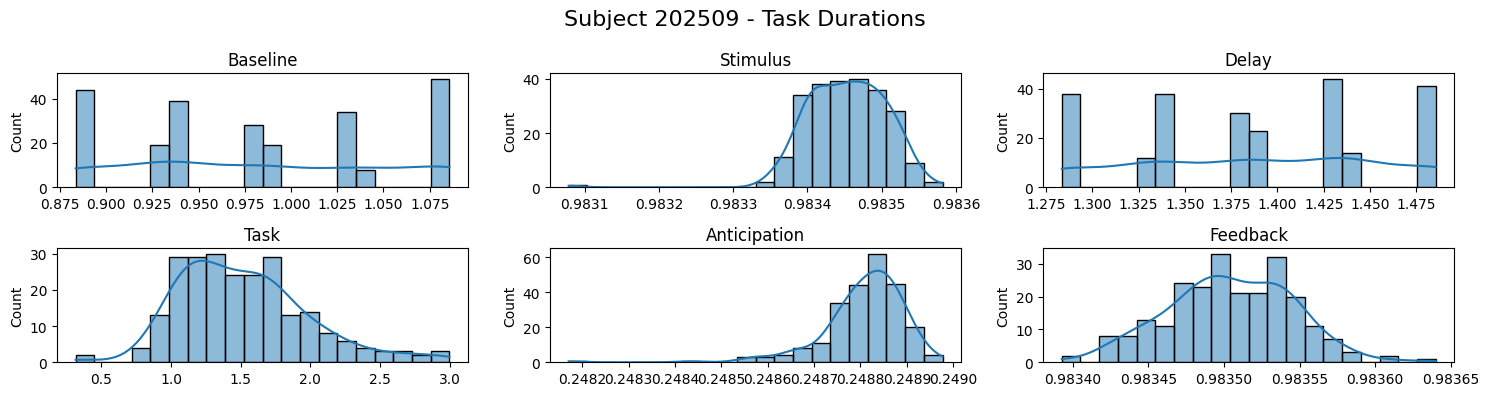

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       230, 231, 232, 233, 234, 235, 236, 237, 238, 239],
      dtype='int64', length=240)


In [16]:
df['base_dur'] = df['baseline.stopped'] - df['baseline.started']
df['stim_dur'] = df['stim.stopped'] - df['target_stim.started']
df['delay_dur'] = df['delay.stopped'] - df['delay.started']
df['task_dur'] = df['task.stopped'] - df['task.started']
df['anticipation_dur'] = df['anticipation.stopped'] - df['anticipation.started']
df['feedback_dur'] = df['feedback.stopped'] - df['no_resp_text.started']

df_plot = df[1:].copy()
df_plot = df.copy()

fig, axs = plt.subplots(2, 3, figsize=(15, 4))
axs, ax = axs.flatten(), 0

sns.histplot(df_plot['base_dur'], bins=20, kde=True, ax=axs[ax])
axs[ax].set(title='Baseline', xlabel='', ylabel='Count')
ax += 1

sns.histplot(df_plot['stim_dur'], bins=20, kde=True, ax=axs[ax])
axs[ax].set(title='Stimulus', xlabel='', ylabel='Count')
ax += 1

sns.histplot(df_plot['delay_dur'], bins=20, kde=True, ax=axs[ax])
axs[ax].set(title='Delay', xlabel='', ylabel='Count')
ax += 1

sns.histplot(df_plot['task_dur'], bins=20, kde=True, ax=axs[ax])
axs[ax].set(title='Task', xlabel='', ylabel='Count')
ax += 1

sns.histplot(df_plot['anticipation_dur'], bins=20, kde=True, ax=axs[ax])
axs[ax].set(title='Anticipation', xlabel='', ylabel='Count')
ax += 1

sns.histplot(df_plot['feedback_dur'], bins=20, kde=True, ax=axs[ax])
axs[ax].set(title='Feedback', xlabel='', ylabel='Count')

plt.suptitle(f'Subject {subj} - Task Durations', fontsize=16)
plt.tight_layout()
plt.show()

# print which rows have feedback less than .99
print(df.loc[df['feedback_dur'] < 0.998].index)


## 1. analyses by valence & compression

condition
baseline     80
curv_comp    80
flat_comp    80
Name: count, dtype: int64
correct
1.0    189
0.0     51
Name: count, dtype: int64
outcome
 3.0    100
 1.0     89
-3.0     31
-1.0     20
Name: count, dtype: int64


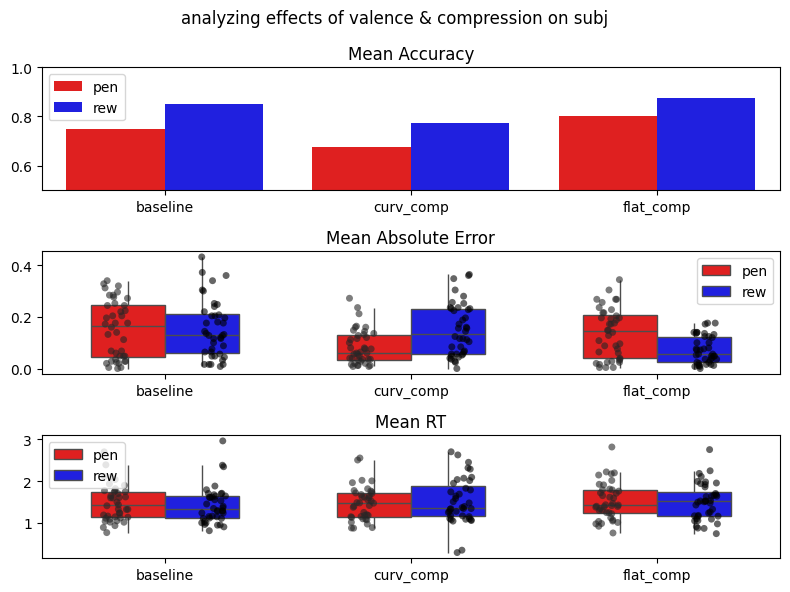

In [17]:
# df_plot = df_hard.copy()
df_plot = df.copy()

df_plot['correct'] = df_plot['correct'].apply(lambda x: 0 if x == -1 else x)
print(df_plot['condition'].value_counts())
print(df_plot['correct'].value_counts())
print(df_plot['outcome'].value_counts())

fig, axes = plt.subplots(3, 1, figsize=(8, 6))
axes = axes.flatten()
fig.suptitle('analyzing effects of valence & compression on subj')
palette, hue_order = {'rew': 'blue', 'pen': 'red'}, ['pen', 'rew']

# 1. accuracy
ax = axes[0]
sns.barplot(data=df_plot, x='condition', y='correct', hue='valence', hue_order=hue_order, palette = palette, ax=ax, errorbar=None)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_ylim(.5, 1)
ax.set_title('Mean Accuracy')
ax.legend()

# 2.
ax = axes[1]
sns.boxplot(data=df_plot, x='condition', y='MAE_unnormed', hue='valence', hue_order = hue_order,
            palette = palette, showcaps=False, fliersize=0, width=0.6, ax=ax)
sns.stripplot(data=df_plot, x='condition', y='MAE_unnormed', hue='valence', hue_order = hue_order, 
              dodge=True, color='black', alpha=0.6, jitter=True, legend=False, ax=ax)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('Mean Absolute Error')
ax.legend()

# 3.
ax = axes[2]
sns.boxplot(data=df_plot, x='condition', y='trials.submit_resp.rt', hue='valence', hue_order = hue_order,
            palette = palette, showcaps=False, fliersize=0, width=0.6, ax=ax)
sns.stripplot(data=df_plot, x='condition', y='trials.submit_resp.rt', hue='valence', 
              dodge=True, color='black', alpha=0.6, jitter=True, legend=False, ax=ax)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('Mean RT')
ax.legend()


plt.tight_layout()
plt.show()

## analyses by valence space

percept_space
curvy         60
very_curvy    60
very_flat     60
flat          60
Name: count, dtype: int64


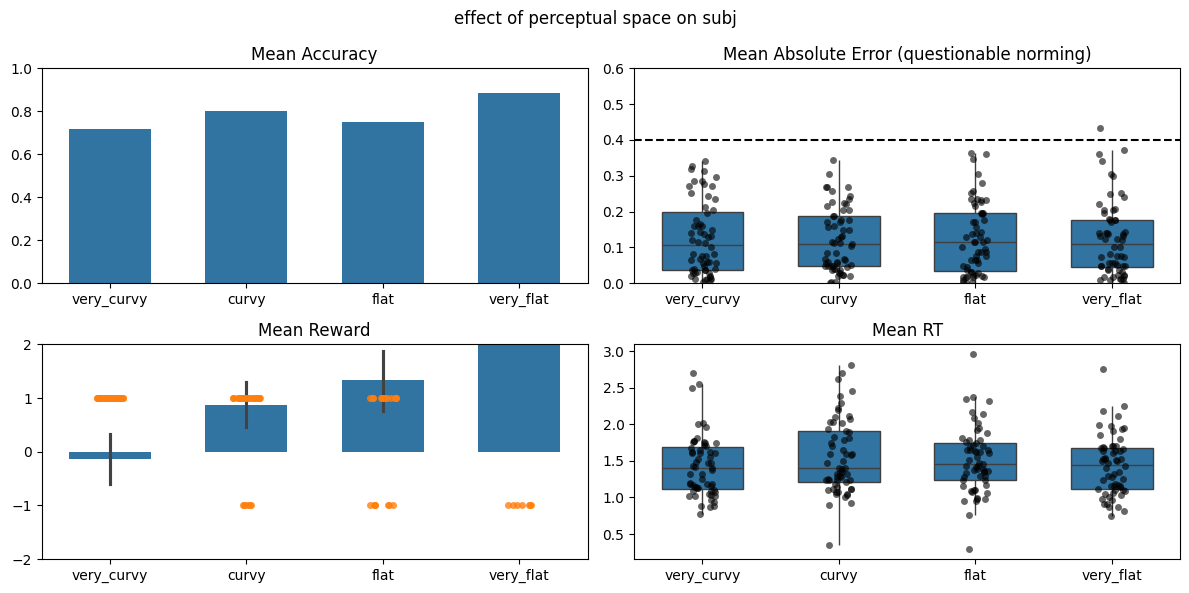

In [18]:
df_plot = df.copy()

conditions = [
    (-0.4 < df_plot['stim_pos']) & (df_plot['stim_pos'] < -0.2),
    (-0.2 < df_plot['stim_pos']) & (df_plot['stim_pos'] < 0),
    (0 < df_plot['stim_pos']) & (df_plot['stim_pos'] < 0.2),
    (0.2 < df_plot['stim_pos']) & (df_plot['stim_pos'] < 0.4)
]
percept_labels = ['very_curvy', 'curvy', 'flat', 'very_flat']
df_plot['percept_space'] = np.select(conditions, percept_labels, default= 'undefined')

# arnav's percept space will be flipped
print(df_plot['percept_space'].value_counts())

fig, axes = plt.subplots(2, 2, figsize=(12, 6))
axes = axes.flatten()
fig.suptitle('effect of perceptual space on subj')

# 1. accuracy
ax = axes[0]
sns.barplot(data=df_plot, x='percept_space', y='correct', width=0.6, ax=ax, errorbar=None, order=percept_labels)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_ylim(0, 1)
ax.set_title('Mean Accuracy')

# 2. MAE
ax = axes[1]
sns.boxplot(data=df_plot, x='percept_space', y='MAE_normed', showcaps=False, fliersize=0, width=0.6, ax=ax, order=percept_labels)
sns.stripplot(data=df_plot, x='percept_space', y='MAE_normed', color='black', dodge=True, alpha=0.6, jitter=True, legend=False, order=percept_labels, ax=ax)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_ylim(0, .6)
ax.axhline(y=.4, color='black', linestyle='--', label = 'max error on correct side')
ax.set_title('Mean Absolute Error (questionable norming)')

# 3. reward
ax = axes[2]
sns.barplot(data=df_plot, x='percept_space', y='outcome', width=0.6, hue_order=hue_order, order=percept_labels, ax=ax)
sns.stripplot(data=df_plot, x='percept_space', y='outcome', dodge=True, alpha=0.8, jitter=True, order=percept_labels, legend=False, ax=ax)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_ylim(-2, 2)
ax.set_title('Mean Reward')

# 4. RT
ax = axes[3]
sns.boxplot(data=df_plot, x='percept_space', y='trials.submit_resp.rt', showcaps=False, fliersize=0, width=0.6, ax=ax, order=percept_labels)
sns.stripplot(data=df_plot, x='percept_space', y='trials.submit_resp.rt', color='black', dodge=True, alpha=0.6, jitter=True, order=percept_labels, legend=True, ax=ax)

ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('Mean RT')

plt.tight_layout()
plt.show()



## pred-true position

In [19]:
df

,thisN,thisTrialN,thisRepN,blockN,run,condition,trial_key,stim_file_pos,stim_pos,noise_pos,...,MAE_normed,dist,avg_speed,choice,base_dur,stim_dur,delay_dur,task_dur,anticipation_dur,feedback_dur
0,0.0,0.0,0.0,1.0,1.0,baseline,10.0,1.1,-0.18,1.0,...,0.244,0.200,0.083771,0,0.984188,0.983078,1.433738,2.415475,0.248761,0.983505
1,1.0,1.0,0.0,1.0,1.0,baseline,7.0,0.7,-0.26,1.0,...,0.160,0.280,0.158248,0,0.885377,0.983446,1.334925,1.797696,0.248723,0.983523
2,2.0,2.0,0.0,1.0,1.0,baseline,37.0,3.7,0.34,3.0,...,0.204,0.000,0.000000,0,0.935482,0.983486,1.383974,1.031866,0.248771,0.983545
3,3.0,3.0,0.0,1.0,1.0,baseline,14.0,1.5,-0.10,1.0,...,0.036,0.144,0.116655,0,0.984408,0.983455,1.334276,1.264647,0.248702,0.983508
4,4.0,4.0,0.0,1.0,1.0,baseline,8.0,0.9,-0.22,1.0,...,0.276,0.120,0.110404,0,1.084197,0.983425,1.484996,1.113990,0.248821,0.983528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,35.0,35.0,0.0,6.0,2.0,flat_comp,212.0,2.3,0.06,3.0,...,0.004,0.424,0.236969,0,1.033963,0.983397,1.383564,1.815711,0.248858,0.983503
236,36.0,36.0,0.0,6.0,2.0,flat_comp,234.0,3.7,0.34,1.0,...,0.072,0.056,0.063931,0,0.984186,0.983398,1.383773,0.898815,0.248867,0.983530
237,37.0,37.0,0.0,6.0,2.0,flat_comp,232.0,3.7,0.34,1.0,...,0.076,0.464,0.308288,0,0.935115,0.983480,1.385358,1.530604,0.248730,0.983582
238,38.0,38.0,0.0,6.0,2.0,flat_comp,205.0,1.5,-0.10,3.0,...,0.204,0.112,0.108230,0,0.933741,0.983458,1.434310,1.065048,0.248811,0.983500


In [15]:
for run, run_df in df.groupby('run'):
    run_df
    break